## Forecasting - Facebook Prophet

https://facebook.github.io/prophet/

https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/

https://peerj.com/preprints/3190.pdf

In [31]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

#import plotly.graph_objects as go

In [32]:
#attention might have problems with holiday package, 
#downgrate holidays via: pip install 'holidays==0.9.12'
from fbprophet import Prophet

In [33]:
%matplotlib inline
plt.style.use('fivethirtyeight')

## Trivial Forecast (rolling mean)

In [34]:
df = pd.DataFrame({'X': np.arange(0,10)}) # generate an input df
df['y']=df.rolling(3).mean() # take the window and write the average as the result

In [35]:
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


## Small Data Set

In [36]:
df_all = pd.read_csv('C:/ProgramData/Anaconda3/eps_covid19/data/processed/COVID_small_flat_table.csv',sep=';')
df=df_all[['date','Germany']]
df=df.rename(columns={'date': 'ds',
                        'Germany': 'y'})

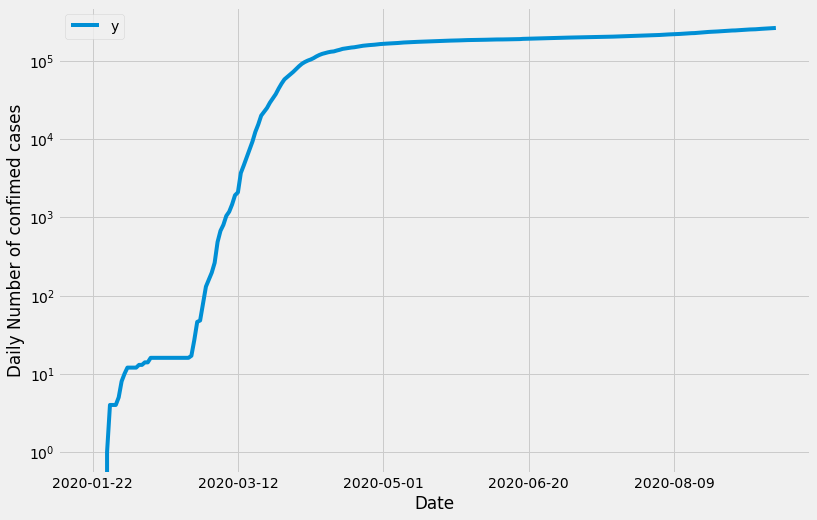

In [37]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()

In [38]:
# set the uncertainty interval to 95% (the Prophet default is 80%)

my_model = Prophet(interval_width=0.95) # piecwise linear model
#my_model = Prophet(growth='logistic')   # logistic model

In [39]:
# the column 'cap' is only mandatory for the logistic model
df['cap']=1000000.

my_model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
# define the periods and the frequency 'D'== days

future_dates = my_model.make_future_dataframe(periods=7, freq='D')
future_dates['cap']=1000000. # only mandatory for the logistic model
future_dates.tail()

,ds,cap
238,2020-09-16,1000000.0
239,2020-09-17,1000000.0
240,2020-09-18,1000000.0
241,2020-09-19,1000000.0
242,2020-09-20,1000000.0


In [41]:
# predict according to the scikit-learn standard

forecast = my_model.predict(future_dates)

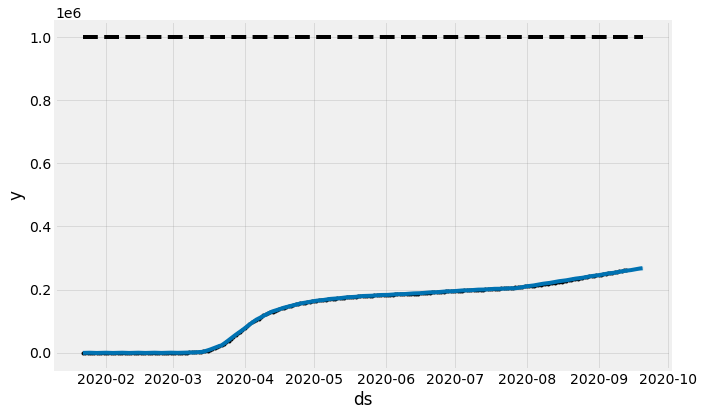

In [42]:
my_model.plot(forecast,
              uncertainty=True ); # since fbprohet is rendering the output

In [43]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)

In [44]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-71.412013,1000000.0,-1998.713993,1380.701582,-71.412013,-71.412013,-200.444690,-200.444690,-200.444690,-200.444690,-200.444690,-200.444690,0.0,0.0,0.0,-271.856702
1,2020-01-23,-67.500790,1000000.0,-1659.972102,1612.710464,-67.500790,-67.500790,76.463550,76.463550,76.463550,76.463550,76.463550,76.463550,0.0,0.0,0.0,8.962759
2,2020-01-24,-63.589568,1000000.0,-1198.833932,1927.096682,-63.589568,-63.589568,426.819318,426.819318,426.819318,426.819318,426.819318,426.819318,0.0,0.0,0.0,363.229750
3,2020-01-25,-59.678346,1000000.0,-1310.019496,1784.573826,-59.678346,-59.678346,333.194839,333.194839,333.194839,333.194839,333.194839,333.194839,0.0,0.0,0.0,273.516493
4,2020-01-26,-55.767124,1000000.0,-1677.432016,1522.341815,-55.767124,-55.767124,12.358522,12.358522,12.358522,12.358522,12.358522,12.358522,0.0,0.0,0.0,-43.408602


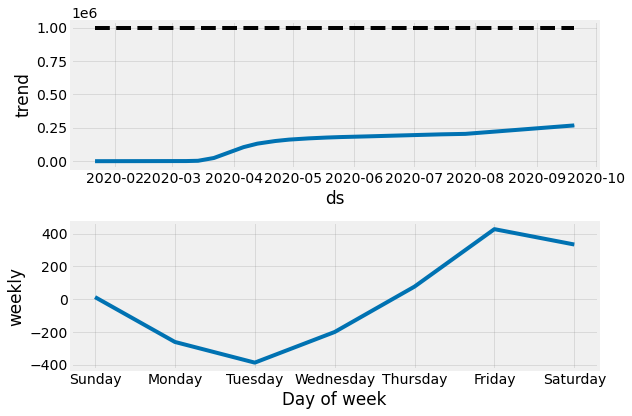

In [45]:
my_model.plot_components(forecast);

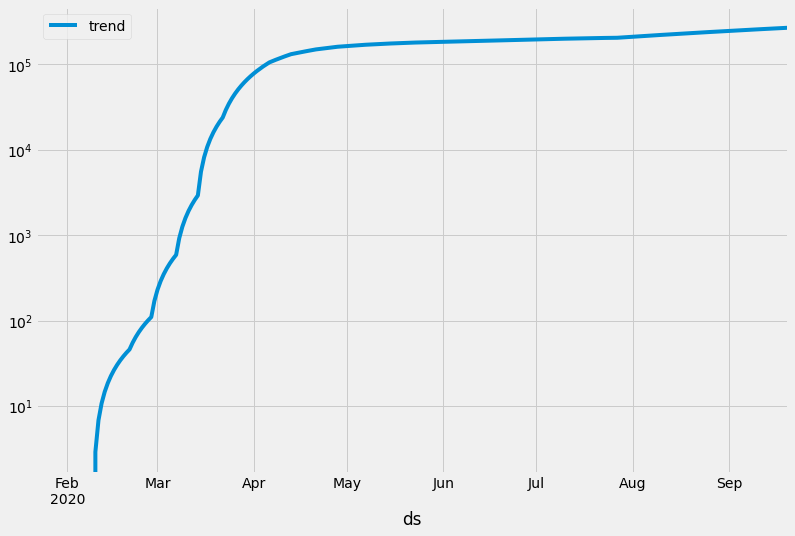

In [46]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

## Cross Validation

In [47]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='30 days', # we take the first 30 days for training
                         period='1 days',  # every  days a new prediction run
                         horizon = '7 days') #we predict 7days into the future
df_cv.head()

INFO:fbprophet:Making 199 forecasts with cutoffs between 2020-02-21 00:00:00 and 2020-09-06 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-22,20.608740,16.657543,24.567553,16,2020-02-21
1,2020-02-23,21.358931,17.473364,25.240738,16,2020-02-21
2,2020-02-24,22.109170,18.435471,25.800396,16,2020-02-21
3,2020-02-25,23.359512,19.412567,27.096575,17,2020-02-21
4,2020-02-26,23.230436,19.309638,27.181260,27,2020-02-21


In [48]:
df_cv.sort_values(by=['cutoff','ds'])[0:14]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-22,20.608740,16.657543,24.567553,16,2020-02-21
1,2020-02-23,21.358931,17.473364,25.240738,16,2020-02-21
2,2020-02-24,22.109170,18.435471,25.800396,16,2020-02-21
3,2020-02-25,23.359512,19.412567,27.096575,17,2020-02-21
4,2020-02-26,23.230436,19.309638,27.181260,27,2020-02-21
5,2020-02-27,23.230575,19.240250,27.530686,46,2020-02-21
6,2020-02-28,23.630761,19.964219,27.673735,48,2020-02-21
7,2020-02-23,20.925977,16.851177,25.384153,16,2020-02-22
8,2020-02-24,21.675761,17.744671,25.596668,16,2020-02-22
9,2020-02-25,22.925494,19.081590,26.985474,17,2020-02-22


In [49]:
df[['ds','y']][30:50]

,ds,y
30,2020-02-21,16
31,2020-02-22,16
32,2020-02-23,16
33,2020-02-24,16
34,2020-02-25,17
35,2020-02-26,27
36,2020-02-27,46
37,2020-02-28,48
38,2020-02-29,79
39,2020-03-01,130


In [50]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [51]:
# the performance matrix shows the result for all horizon
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,5.290421e+07,7273.527702,4063.497264,0.141511,0.017188,0.221106
1,2 days,7.196341e+07,8483.124964,4812.127077,0.152301,0.019852,0.231156
2,3 days,9.582201e+07,9788.871535,5603.805314,0.161586,0.021509,0.281407
3,4 days,1.239208e+08,11131.969989,6427.221633,0.169600,0.024014,0.356784
4,5 days,1.576055e+08,12554.101206,7301.764537,0.176997,0.025906,0.402010
5,6 days,1.968080e+08,14028.828737,8212.790280,0.185244,0.027774,0.427136
6,7 days,2.405936e+08,15511.081446,9157.525251,0.191428,0.030124,0.462312


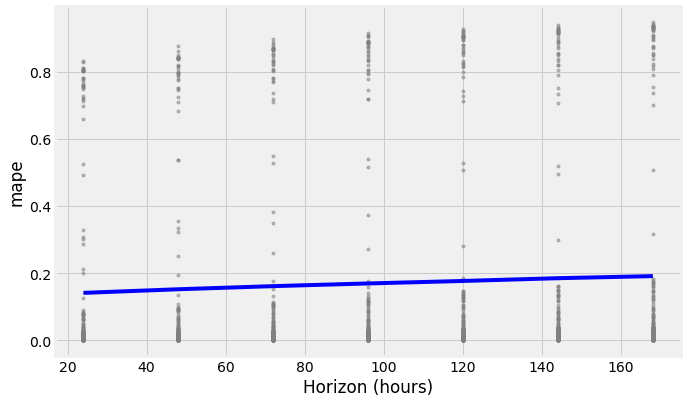

In [52]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

## Diagonalplot

gives a good understanding for the under and over estimation w.r.t. magnitude

In [53]:
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [54]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
1364,2020-09-09,251099.733533,245961.299699,255144.184609,256433,2020-09-02,7 days
1371,2020-09-10,252628.799497,246700.944554,258364.327851,258149,2020-09-03,7 days
1378,2020-09-11,254442.185989,248871.518867,259835.512091,259735,2020-09-04,7 days
1385,2020-09-12,255878.851092,250857.612319,261353.923863,260817,2020-09-05,7 days
1392,2020-09-13,257087.652057,252434.564371,262850.436890,261737,2020-09-06,7 days


In [55]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

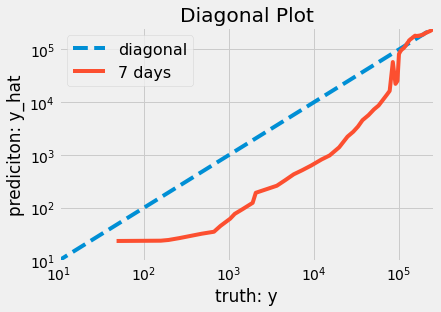

In [56]:
fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16})


## Trivial Forecast

In [57]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Example trivial forecast, prediciton 7 days into the future

In [58]:
parse_dates=['date']
df_all = pd.read_csv('C:/ProgramData/Anaconda3/eps_covid19/data/processed/COVID_small_flat_table.csv',sep=';',parse_dates=parse_dates)
df_trivial=df_all[['date','Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'Germany': 'y'})

In [59]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean() # take the average of 3 days

In [60]:
# the result has to be shifted according to the prediciton horizon (here 7 days) But Why?

df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))

df_trivial.head()

MAPE: 127.6807888473055


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.0,NaT,NaN,NaT
3,2020-01-25,0,0.0,NaT,NaN,NaT
4,2020-01-26,0,0.0,NaT,NaN,NaT
